In [1]:
# ! pip install pip install PyPortfolioOpt

In [316]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
from pypfopt.hierarchical_portfolio import HRPOpt
from datetime import date
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

## Data Handling

In [317]:
data = pd.read_csv('data.csv').dropna()
data.set_index('timeclose',inplace=True)
data.reset_index(inplace=True)

#Format Dates by removing timestamps

data.rename(columns={'timeclose':'Date'},inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.date
data['Date'] = data['Date'].astype('datetime64[ns]')



In [318]:
#Averaging over timestamps in a day

data = data.groupby('Date').mean()
data.reset_index(inplace=True)

In [319]:
# Add columns for years and months

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

yr= sorted(data.Year.unique())
mo= sorted(data.Month.unique())



In [320]:
#Drop one data point causing trouble

data.set_index(['Month','Year'],inplace=True)
data.drop((1,2022),inplace=True)
data.reset_index(inplace=True)


In [321]:
#Create list of data frames for every month's data

df = []
for i in yr:
    for j in mo:
        d = data[(data['Month'] == j) & (data['Year']==i)]
        if d.empty:
            continue
        else:
            df.append(d)

## Hierarchial Risk Parity (for entire data)

In [322]:
#HRP Model

new_data = data.drop(columns=['Month','Year'])
new_data.set_index('Date', inplace=True)
HRP = HRPOpt(new_data,new_data.cov)

In [323]:
#Weights for Minimum Var Portfolio  using Hierarchial Risk Parity Algorithm
w_vector = HRP.optimize(linkage_method='single')
weights= w_vector.values()


In [324]:
#Model Performance for total number of days in dataset 

hrp_vol = HRP.portfolio_performance(weights)[1]*100
hrp_rtrn = HRP.portfolio_performance(weights)[0]*100


Expected annual return: 0.1%
Annual volatility: 0.3%
Sharpe Ratio: -5.58
Expected annual return: 0.1%
Annual volatility: 0.3%
Sharpe Ratio: -5.58


## Monthly HRP

In [325]:
hrp_list = []

for i in range(0,len(df)):

    dataset= df[i]
    month= dataset.Month.unique()[0]
    year= dataset.Year.unique()[0]
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataset= df[i].drop(columns=['Month','Year']).dropna()
    dataset.set_index('Date', inplace=True)

    HRP_m = HRPOpt(dataset,np.cov)
    w_vector_m = HRP_m.optimize()
    weights_m= w_vector_m.values()
    performance_m = HRP_m.portfolio_performance(risk_free_rate= 0.036)
    rtrn_m = performance_m[0]*100
    vol_m = performance_m[1]*100
    hrp_list.append([month,year,rtrn_m,vol_m])


C:\Users\Nilakshi Mondal\Anaconda3\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


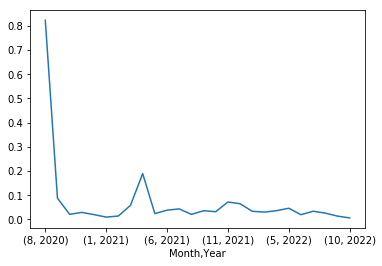

In [326]:
#Plotting

hrp_df = pd.DataFrame(hrp_list, columns=["Month","Year","Returns", "Volatility"])
hrp_df.set_index(['Month','Year'],inplace=True)
hrp_df['Volatility'].plot(x='Volatility')

##  Markowitz (for entire data)

In [327]:
# Returns and Cov Matrix

returns = new_data.mean()

cov_matrix = new_data.cov()

# data.apply(gmean)
#geomtric means cannot be applied or negative numbers/zeros. In that case need log returns instead of pct_change for prices

In [328]:
# Weights
random.seed(0)
weights = np.random.random(15)
weights /= weights.sum()

#Define number of portfolios (Assuming 100)

n_port =100


In [345]:
#Expected Portfolio Returns

port_rtrn = returns.dot(weights)*100


In [346]:
# Markovitz Model

#@ operator - shorthand for np.matmul (matrix multiplication)
port_var = np.transpose(weights)@cov_matrix@weights
port_vol = np.sqrt(port_var)*np.sqrt(252)


## Monthly Markovitz

In [347]:
marko_list = []
vol = 1

for i in range(0,len(df)):
       
    dataset= df[i]
    month= dataset.Month.unique()[0]
    year= dataset.Year.unique()[0]
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataset= df[i].drop(columns=['Month','Year']).dropna()
    dataset.set_index('Date', inplace=True)

    vol = 1
    for j in range(0,n_port):
        
        random.seed(0)
        weights1 = np.random.random(15)
        weights1 /= weights1.sum()
        portrtrn = returns.dot(weights1)*100
        portvar = np.transpose(weights1)@cov_matrix@weights1
        portvol = np.sqrt(portvar)*np.sqrt(252)*100
        if portvol< vol:
            vol = portvol
        else:
            continue
    marko_list.append([month,year,portrtrn,vol])


C:\Users\Nilakshi Mondal\Anaconda3\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


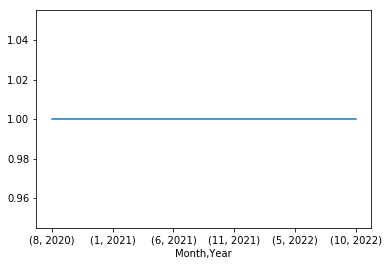

In [348]:
#Plotting

marko_df = pd.DataFrame(marko_list, columns=["Month","Year","Returns", "Volatility"])
marko_df.set_index(['Month','Year'],inplace=True)
marko_df['Volatility'].plot(x='Volatility')

## Actual Vol (Entire Data)

In [349]:
act_vol =new_data.std().std(axis=0)


## Actual Vol Monthly

In [350]:
mon_vol= data.groupby(['Year','Month']).std().std(axis=1)


## Plot ALL

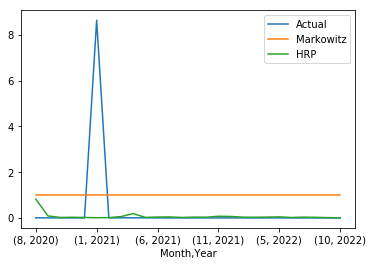

In [351]:
#Monthly Volatility

fig,ax= plt.subplots()
mon_vol.dropna().plot(label='Actual')
marko_df['Volatility'].plot(x='Volatility',label='Markowitz')
hrp_df['Volatility'].plot(x='Volatility',label='HRP')
ax.legend()

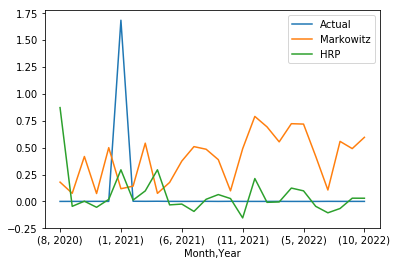

In [352]:
#Monthly Returns

mon_rtrn = data.groupby(['Year','Month']).mean().mean(axis=1)

fig,ax= plt.subplots()
mon_rtrn.dropna().plot(label='Actual')
marko_df['Returns'].plot(x='Returns',label='Markowitz')
hrp_df['Returns'].plot(x='Returns',label='HRP')
ax.legend()

## Performance Measure


In [353]:
#Volatility

#Markowitz
mv =mean_squared_error(mon_vol.dropna(),marko_df['Volatility'])

#HRP
hv =mean_squared_error(mon_vol.dropna(),hrp_df['Volatility'])

In [354]:
#Returns

#Markowitz
mr =mean_squared_error(mon_rtrn,marko_df['Returns'])

#HRP
hr =mean_squared_error(mon_rtrn,hrp_df['Returns'])

In [355]:
final_df = pd.DataFrame([[port_rtrn,hrp_rtrn],[port_vol,hrp_vol]], index=['Returns','Volatility'],columns=['Markowitz','Hierarchial Risk Parity'])

In [356]:
#Results for Entire Data
final_df

,Markowitz,Hierarchial Risk Parity
Returns,0.510137,0.126062
Volatility,2.132961,0.335700


In [357]:
perf_df = pd.DataFrame([[mr,hr],[mv,hv]], index=['Returns MSE','Volatility MSE'],columns=['Markowitz','Hierarchial Risk Parity'])

In [358]:
#Performance Measure
perf_df

,Markowitz,Hierarchial Risk Parity
Returns MSE,0.302162,0.112572
Volatility MSE,3.207418,2.897977
